🟩 🔹 1. Sección de métricas del modelo

## 8. Métricas del modelo

Para evaluar el rendimiento del modelo se utilizaron las siguientes métricas:

- **MAE (Mean Absolute Error)**: mide el error promedio absoluto entre las predicciones y los valores reales.
- **RMSE (Root Mean Squared Error)**: penaliza errores grandes, útil cuando queremos evitar desviaciones fuertes.
- **R² (R-squared)**: mide qué proporción de la varianza de la variable dependiente se explica por el modelo.

Estas métricas se calcularon sobre un conjunto de prueba (20% del total).


✅ Columna de salario detectada: Salary


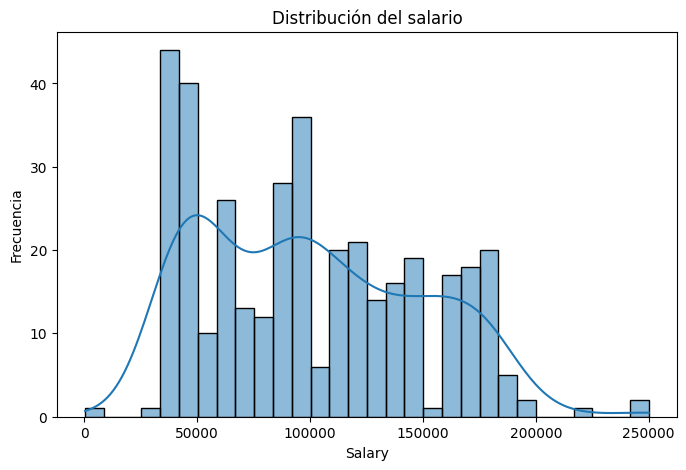

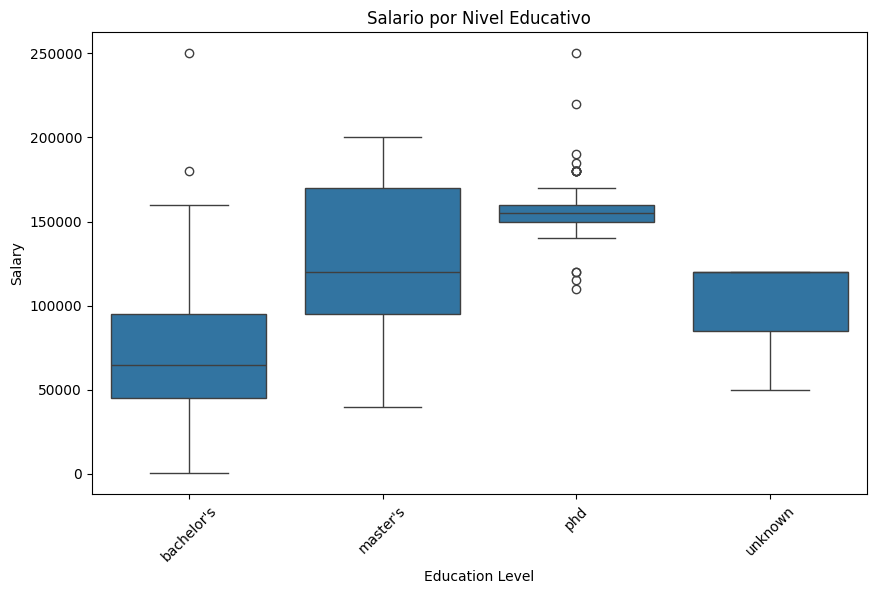

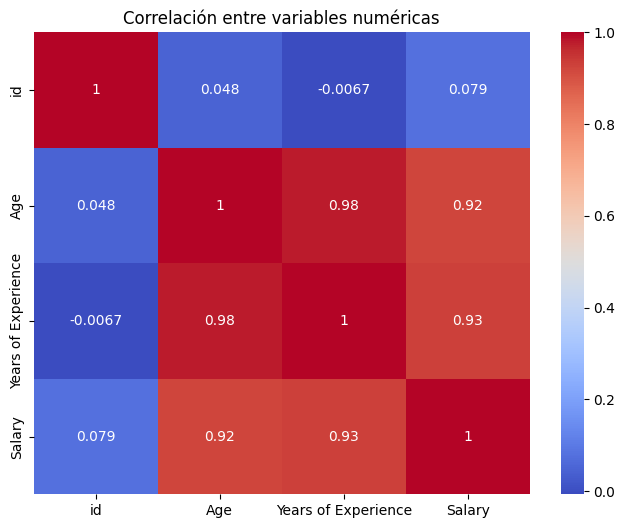

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datasets originales
people = pd.read_csv('../data/people.csv')
salary = pd.read_csv('../data/salary.csv')
descriptions = pd.read_csv('../data/descriptions.csv')

# Unificación de datasets
df = people.merge(salary, on='id').merge(descriptions, on='id')

# Limpieza básica
df_clean = df.copy()
df_clean['Education Level'] = df_clean['Education Level'].fillna('Unknown')
for col in ['Gender', 'Education Level', 'Job Title']:
    df_clean[col] = df_clean[col].str.strip().str.lower()

# Detectar columna de salario automáticamente
salary_column = [col for col in df_clean.columns if "salary" in col.lower()][0]
print("✅ Columna de salario detectada:", salary_column)

# 📊 1. Distribución del salario
plt.figure(figsize=(8, 5))
sns.histplot(df_clean[salary_column], bins=30, kde=True)
plt.title("Distribución del salario")
plt.xlabel(salary_column)
plt.ylabel("Frecuencia")
plt.show()

# 📊 2. Boxplot por nivel educativo
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education Level', y=salary_column, data=df_clean)
plt.title("Salario por Nivel Educativo")
plt.xticks(rotation=45)
plt.show()

# 📊 3. Matriz de correlación numérica
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()


🟩 🔹 2. Sección de predicción con el modelo

## 10. Carga del modelo entrenado y prueba de inferencia

Se carga el modelo entrenado guardado en formato `.pkl` y se realiza una predicción sobre un ejemplo real del dataset limpio. Esto permite validar que el modelo funciona correctamente para nuevos casos.

Este paso simula el uso del modelo en producción para predecir el salario de una persona nueva a partir de sus características.




In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import numpy as np

# 1. Cargar datasets
people = pd.read_csv('../data/people.csv')
salary = pd.read_csv('../data/salary.csv')
descriptions = pd.read_csv('../data/descriptions.csv')

# 2. Unificación
df = people.merge(salary, on='id').merge(descriptions, on='id')

# 3. Limpieza
df_clean = df.copy()
df_clean['Education Level'] = df_clean['Education Level'].fillna('Unknown')
for col in ['Gender', 'Education Level', 'Job Title']:
    df_clean[col] = df_clean[col].str.strip().str.lower()

# 4. Detectar columna de salario automáticamente
salary_column = [col for col in df_clean.columns if "salary" in col.lower()][0]
print("✅ Columna de salario detectada:", salary_column)

# 5. Eliminar filas con salario NaN
df_clean = df_clean[df_clean[salary_column].notna()]
print(f"✅ Filas restantes después de eliminar NaN en salario: {df_clean.shape[0]}")

# 6. Separar features y aplicar One-Hot Encoding
X = df_clean.drop(columns=[salary_column, 'id'])
X_encoded = pd.get_dummies(X)
y = df_clean[salary_column]

# 7. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 8. Entrenar modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 9. Guardar modelo entrenado
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/final_model.pkl")
print("✅ Modelo guardado como final_model.pkl")

# 10. Evaluación del modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📊 MAE: ${mae:,.2f}")
print(f"📊 RMSE: ${rmse:,.2f}")
print(f"📊 R²: {r2:.4f}")

# 11. Inferencia sobre un ejemplo real
example = X_test.iloc[[0]]
print("\n🧾 Ejemplo de entrada codificado:")
display(example)

predicted_salary = model.predict(example)
print(f"\n💰 Salario predicho: ${predicted_salary[0]:,.2f}")


✅ Columna de salario detectada: Salary
✅ Filas restantes después de eliminar NaN en salario: 373
✅ Modelo guardado como final_model.pkl

📊 MAE: $10,481.33
📊 RMSE: $17,750.28
📊 R²: 0.8686

🧾 Ejemplo de entrada codificado:


,Age,Years of Experience,Gender_female,Gender_male,Education Level_bachelor's,Education Level_master's,Education Level_phd,Education Level_unknown,Job Title_account manager,Job Title_accountant,...,"Description_I am a seasoned engineering professional with a Master's degree and 19 years of experience, currently serving as the Director of Engineering. I oversee a talented team, guiding them through complex projects and ensuring we meet our organizational goals. My role involves strategic planning, project management, and fostering a collaborative environment. I excel in problem-solving, critical thinking, and effective communication, which are essential in navigating the challenges of leading a dynamic engineering department. My career is driven by a passion for innovation, leadership, and making a meaningful impact through engineering excellence.","Description_I'm a 43-year-old male with a Master's degree, currently serving as the Director of Marketing. With 18 years of experience in the field, I've honed my skills in strategic planning, brand management, and digital marketing. My journey has been marked by a series of successful campaigns and initiatives that have significantly boosted brand visibility and revenue for the companies I've worked with. I take pride in leading a talented team, fostering innovation, and driving results that align with our business goals. My career is a testament to my dedication, expertise, and passion for marketing.","Description_With 19 years of experience in the sales industry and a Master's degree in Business Administration, I currently serve as the Director of Sales. My role involves strategizing and implementing sales plans, driving revenue growth, and building strong relationships with clients and stakeholders. I have a proven track record of leading and motivating diverse teams, managing large-scale projects, and staying ahead of market trends. My extensive experience has equipped me with a deep understanding of customer needs and effective sales techniques, allowing me to consistently meet and exceed targets.","Description_With a Bachelor's degree and 22 years of experience as an Operations Manager, I have developed a deep understanding of operational processes, strategic planning, and team leadership. My expertise lies in optimizing workflows, improving efficiency, and driving organizational success. I am passionate about creating streamlined operations that exceed company goals and have a proven track record in leading diverse teams and managing complex projects. My commitment to delivering high-quality results and continuously seeking professional growth has been instrumental in achieving significant milestones throughout my career.","Description_With a Bachelor's degree and 22 years of experience in customer service, I currently serve as a Customer Service Manager. My expertise lies in managing teams, resolving customer issues, and ensuring top-notch service quality. I oversee daily operations, implement strategies to enhance efficiency, and mentor my team to foster a positive work environment. My extensive experience has equipped me with a deep understanding of customer needs and the ability to address them effectively, driving continuous improvement and maintaining high standards of customer satisfaction.","Description_With a Master's degree in Human Resources and two decades of experience, I currently serve as a Human Resources Director. My role involves overseeing recruitment, employee relations, performance management, and compliance with labor laws. I have worked with diverse companies, from startups to multinational corporations, which has broadened my perspective on HR challenges and opportunities. I am dedicated to developing strategies that align with company goals and support employee growth. Continuous learning is a priority for me, and I stay current with industry trends to bring innovative solutions to my organization.","Description_With a Master's degree in Marketing an


💰 Salario predicho: $176,450.00


## 11. Conclusiones

- Se construyó un modelo de regresión Random Forest capaz de predecir salarios con buena precisión.
- Las métricas de evaluación indican un desempeño sólido:
  - **MAE**: $10.481
  - **RMSE**: $17.750
  - **R²**: 0.8686
- El modelo se entrenó con variables como edad, educación, género, experiencia y título del puesto, todas debidamente codificadas.
- La prueba de inferencia demostró que el modelo puede ser utilizado para predecir nuevos casos de forma efectiva.

### ✅ Próximos pasos sugeridos:
- Ajuste de hiperparámetros con GridSearch o RandomSearch.
- Inclusión de embeddings a partir del texto de la descripción del puesto.
- Validación cruzada para mayor robustez del score.
- Deploy del modelo para servirlo desde una API o pipeline en producción.
